# 04 - pyLDAvis and LSA Plots

## 1. Import Packages <a name="import"></a>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import nltk
# nltk.download()

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import textstat

In [12]:
import pickle
import json, csv
import os

import re
import string

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

In [8]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/home/kchiv/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


## Table of Contents <a name="table"></a>
1. [Import Packages](#import)
2. [Load Data](#load)
3. [Selecting an Example](#example)
4. [Topic Modeling Functions](#func)
5. [LSA Plots](#lsa)
6. [pyLDAvis](#lda)

## 2. Load Data <a name="load"></a>

In [18]:
movie_reviews = pd.read_pickle('./data/processed_movie_reviews.pkl.gz', compression = 'gzip')

movie_reviews.head()

,movie_id,review_text,rating,review_summary,similarities_lsa,similarities_lda,similarities_nmf,flesch_reading_ease_score,difficult_words_score,linsear_write_score,compound_score
0,tt0111161,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,0.961052,0.875862,0.899648,70,120,16,0.0000
1,tt0111161,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,0.966842,0.806110,0.925397,69,35,18,0.8402
2,tt0111161,I believe that this film is the best story eve...,8,The best story ever told on film,0.924182,0.783039,0.789735,70,45,14,0.6369
3,tt0111161,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,0.909945,0.881686,0.784359,-6,76,15,0.0000
4,tt0111161,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",0.977627,0.915197,0.942112,63,133,15,0.6249


We add an additional column 'not_spoiler' that indicates whether something is a spoiler or not.

In [20]:
labels = pickle.load(open('./data/labels.pkl', 'rb'))

movie_reviews['not_spoiler'] = labels

movie_reviews.head()

,movie_id,review_text,rating,review_summary,similarities_lsa,similarities_lda,similarities_nmf,flesch_reading_ease_score,difficult_words_score,linsear_write_score,compound_score,not_spoiler
0,tt0111161,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,0.961052,0.875862,0.899648,70,120,16,0.0000,0.0
1,tt0111161,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,0.966842,0.806110,0.925397,69,35,18,0.8402,0.0
2,tt0111161,I believe that this film is the best story eve...,8,The best story ever told on film,0.924182,0.783039,0.789735,70,45,14,0.6369,0.0
3,tt0111161,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,0.909945,0.881686,0.784359,-6,76,15,0.0000,0.0
4,tt0111161,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",0.977627,0.915197,0.942112,63,133,15,0.6249,0.0


Return to [Table of Contents](#table)

## 3. Selecting an Example <a name="example"></a>

We select an example movie to produce visualizations for. <br>

In [26]:
not_spoilers = movie_reviews['not_spoiler'] == 1

top_10_movie_ids = movie_reviews.loc[not_spoilers, 'movie_id'].value_counts()[:10]

top_10_movie_ids = pd.DataFrame(top_10_movie_ids).reset_index()

top_10_movie_ids.columns = ['movie_id', 'counts']

top_10_movie_ids

,movie_id,counts
0,tt0111161,2359
1,tt0137523,1650
2,tt0468569,1488
3,tt0110912,1273
4,tt0068646,1057
5,tt0167260,1017
6,tt0407887,588
7,tt1210819,549
8,tt0108052,538
9,tt1800241,537


In [40]:
movie_details = pd.read_pickle('./data/movie_details.pkl.gz', compression = 'gzip')

movie_details.head()

,movie_id,plot_summary,genre,plot_synopsis,title
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...","[Action, Thriller]","Jack Ryan (Ford) is on a ""working vacation"" in...",Patriot Games
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",[Comedy],Four boys around the age of 10 are friends in ...,Last Vegas
2,tt0126886,Tracy Flick is running unopposed for this year...,"[Comedy, Drama, Romance]",Jim McAllister (Matthew Broderick) is a much-a...,Election
3,tt0286716,"Bruce Banner, a brilliant scientist with a clo...","[Action, Sci-Fi]",Bruce Banner (Eric Bana) is a research scienti...,Hulk
4,tt0090605,57 years after Ellen Ripley had a close encoun...,"[Action, Adventure, Sci-Fi]","After the opening credits, we see a spacecraft...",Aliens


In [41]:
movie_ids_to_title = movie_details[['movie_id', 'title']]

movie_ids_to_title

,movie_id,title
0,tt0105112,Patriot Games
1,tt1204975,Last Vegas
2,tt0126886,Election
3,tt0286716,Hulk
4,tt0090605,Aliens
...,...,...
875,tt0120891,Wild Wild West
876,tt0120655,Dogma
877,tt0276751,About a Boy
878,tt1723811,Shame


In [42]:
top_10_movie_ids.merge(movie_ids_to_title, on = 'movie_id')

,movie_id,counts,title
0,tt0111161,2359,The Shawshank Redemption
1,tt0137523,1650,Fight Club
2,tt0468569,1488,The Dark Knight
3,tt0110912,1273,Pulp Fiction
4,tt0068646,1057,The Godfather
5,tt0167260,1017,The Lord of the Rings: The Return of the King
6,tt0407887,588,The Departed
7,tt1210819,549,The Lone Ranger
8,tt0108052,538,Schindler's List
9,tt1800241,537,American Hustle


I selected 'The Lord of the Rings: The Return of the King' for my visualizations because I was most familiar with it. <br>

In [43]:
movie_id = 'tt0167260'

Return to [Table of Contents](#table)

## 4. Topic Modeling Functions <a name="func"></a>

We first define some functions and helper functions to aid us. <br>
We are mostly reusing the same functions from the '02 - NLP Modeling' notebook. <br>
There is just one slight modification to the `topic_modeling` function. <br>
It now returns the model as well.

In [34]:
#initialize lemmatizer here to avoid re-initialization later
lemmatizer = WordNetLemmatizer()

def text_preprocessing(text):
    """
        Helper function for preprocessing text for vectorization
    
        :param text: raw text as string
        :returns text: preprocessed text as a string
    """
    #match only letters
    text = re.sub('\w*\d\w*', ' ', text) 
    
    #lowercase all text and remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower()) 
    
    #lemmatize text and recombined into one string
    word_list = nltk.word_tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_list]) 
    
    return text

In [35]:
def generate_paragraphs(synopsis):
    """
        The movie synopses come as one string when we need paragraphs.
        This is a helper function to turn a plot synopsis into a paragraph.
        
        :param synopsis: plot synopsis as one string
        
        :returns p_list: a list of paragraph strings from the synopsis
    """

    #turn synopsis into a list of sentence tokens
    synopsis = synopsis.split('.')

    p_list = []

    #specify the number of sentences per paragraph
    p_length = 5

    #lower and upper indices for slicing the list of sentence tokens
    lower = 0
    upper = p_length

    while lower <= len(synopsis):
        #slice the list of sentence tokens from 
        #lower inclusive to upper exclusive
        sentences = synopsis[lower:upper]

        #combine sentences into a single string
        paragraph = '. '.join(sentences)

        p_list.append(paragraph)

        #increment lower and upper indices for next slice 
        lower += p_length
        upper += p_length
    
    return p_list

In [36]:
def vectorize_movie_items(movie_details, movie_reviews, movie_id):
    """
        Function for producing the necessary vector representations
        of the reviews and the plot synopsis for a given movie_id
        
        :param movie_id: string representing which movie to use
        :param movie_details: dataframe containing the plot synopsis of the movie
        :param movie_reviews: dataframe containing the reviews for the movie
        
        :returns vectorizer: vectorizer used to vectorize the text
        :returns synopsis_p_vector: a word matrix representation of self-designated 
                                  paragraphs in the synopsis
        :returns synopsis_vector: a word vector representation of the synopsis
        :returns review_word_matrix: a word matrix representation of the reviews
    """
    
    #preprocess the synopsis
    synopsis = movie_details.loc[movie_details['movie_id'] == movie_id, 'plot_synopsis'].values[0]

    #turn the synopsis from one string into a list of paragraph strings
    synopsis_p = generate_paragraphs(synopsis)

    synopsis_p = [text_preprocessing(paragraph) for paragraph in synopsis_p]

    #preprocess the reviews
    reviews = movie_reviews.loc[movie_reviews['movie_id'] == movie_id, 'review_text'].values
    reviews = [text_preprocessing(review) for review in reviews]
    
    
    #import stopwords and add custom stop words like the title
    #'spoiler' was included as a stopword to make the task of 
    #spoiler detection fairer and more challenging

    stop_words = nltk.corpus.stopwords.words('english')

    new_stop_words = ['actor', 'actress', 'director', 'film', 
                      'movie', 'rating', 'spoiler', 'book']
    
    title = movie_details.loc[movie_details['movie_id'] == movie_id, 'title'].values[0]

    title_words = text_preprocessing(title).split(' ')

    stop_words.extend(new_stop_words)

    
    #vectorize the text
    #CountVectorizer performed reasonably well,
    #perhaps due to most plot points appearing with some frequency
    vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words = stop_words)

    
    #we fit the vectorizer on the synopsis paragraphs
    #however, we also transform the original synopsis 
    #we want to compare each review to the synopsis
    #a review that is very similar to a synopsis is most likely a spoiler
    synopsis_p_vector = vectorizer.fit_transform(synopsis_p)

    synopsis_vector = vectorizer.transform([text_preprocessing(synopsis)])

    review_word_matrix = vectorizer.transform(reviews)
    
    return vectorizer, synopsis_p_vector, synopsis_vector, review_word_matrix

In [37]:
def topic_modeling(synopsis_p_vector, synopsis_vector, review_word_matrix, 
                   vectorizer, model_name, num_components = 15):
    """
        Function for performing topic modeling and dimensionality reducing 
        
        :param synopsis_p_vector: a word matrix representation of self-designated 
                                paragraphs in the synopsis
        :param synopsis_vector: a word vector representation of the synopsis
        :param review_word_matrix: a word matrix representation of the reviews
        :param vectorizer: the vectorizer used before topic modeling
        :param model_name: string name of the model, options limited to 'lda', 'lsa', 'nmf'
        :param num_components: number of components to use in modeling

        :returns synopsis_vector: a topic representation of synopis_vector
        :returns review_word_matrix: a topic representation of review_word_matrix
        :returns model: the model used for topic modeling after fitting
    
    """

    #however, we cannot expect a review with spoiler
    #to contains most of the words and phrases from the synopsis
    #we need to perform some dimensionality reduction via topic modeling
    #this will transform our words into topics
    if model_name == 'lda':        
        model = LatentDirichletAllocation(n_components=num_components, 
                                          random_state=42, learning_method = 'batch')        
    elif model_name == 'lsa':
        model = TruncatedSVD(num_components, random_state = 42)
    elif model_name == 'nmf':
        model = NMF(num_components)

    #we fit our model on synopsis paragraphs
    #this allows to find common topics among the paragraphs
    #the assumption is topics will be related to plot points
    model.fit(synopsis_p_vector)

    #however, we only transform synopsis vector because 
    #we want to compare the whole synopsis to each review, 
    #not each paragraph of the synopsis to each review
    synopsis_vector = model.transform(synopsis_vector)

    #we apply the same tranformation from words to topics on the reviews
    review_topic_matrix = model.transform(review_word_matrix)

    #uncomment the line below if you want to see what topics the model produced
    # display_topics(model, vectorizer.get_feature_names(), 10)
    
    return synopsis_vector, review_topic_matrix, model

Return to [Table of Contents](#table)

## 5. LSA Plots <a name="lsa"></a>

In [44]:
#produce the necessary word vector representations of the reviews and synopsis
vectorizer, synopsis_p_vector, synopsis_vector, review_word_matrix = \
    vectorize_movie_items(movie_details, movie_reviews, movie_id)

In [66]:
#produce the necessary topic representations of the reviews and synopsis
synopsis_topic_vector, review_topic_matrix, lsa = topic_modeling(synopsis_p_vector, synopsis_vector, 
                                                                 review_word_matrix, vectorizer, 'lsa') 

In [67]:
var_ratio = lsa.explained_variance_ratio_

Normally, we would expect an exponentially decaying curve for the explained variance versus the component number. <br>
This is because the first few components usually contribute the most variance due to how SVD functions. <br>
SVD identifies the components with the most variance.

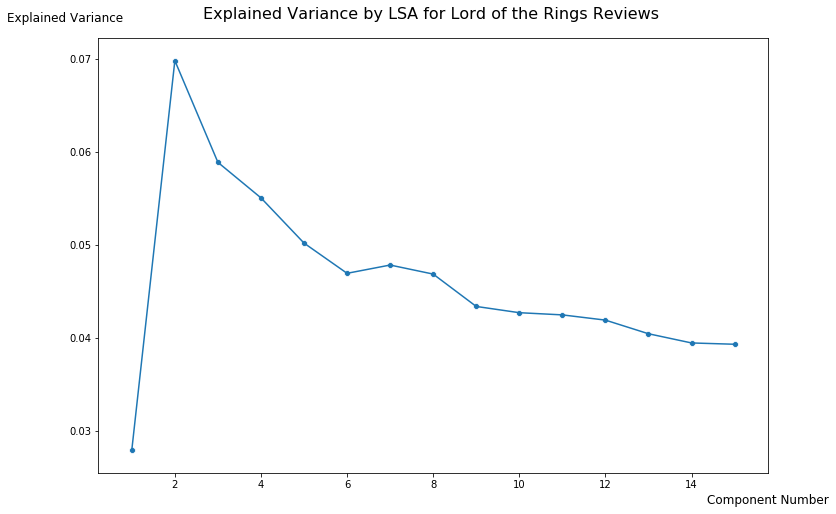

In [68]:
num_components = [i+1 for i in range(len(var_ratio))]
plt.figure(figsize = (12, 8))
sns.lineplot(num_components, var_ratio)
sns.scatterplot(num_components, var_ratio)
plt.title('Explained Variance by LSA for Lord of the Rings Reviews ', fontsize=16, y= 1.03)
plt.xlabel('Component Number', fontsize = 12, x=1.0)
plt.ylabel('Explained Variance', fontsize = 12, y=1.03, rotation=0)
plt.savefig('./img/variance_per_component_lsa.png', bbox_inches = 'tight')

With the number of components we have, this is more than enough for LSA.

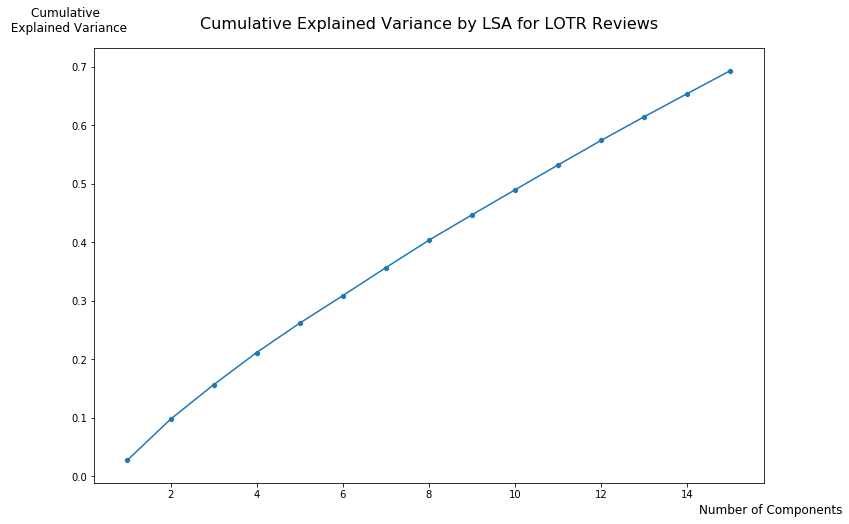

In [69]:
num_components = [i+1 for i in range(len(var_ratio))]
plt.figure(figsize = (12, 8))
cum_variance = np.cumsum(var_ratio)
sns.lineplot(num_components, cum_variance)
sns.scatterplot(num_components, cum_variance)
plt.title('Cumulative Explained Variance by LSA for LOTR Reviews', fontsize=16, y= 1.03)
plt.xlabel('Number of Components', fontsize = 12, x=1.01)
plt.ylabel('Cumulative \n Explained Variance', fontsize = 12, y=1.03, rotation=0)
plt.savefig('./img/cumulative_variance_lsa.png', bbox_inches = 'tight')

Return to [Table of Contents](#table)

## 6. pyLDAvis <a name="lda"></a>

Unfortunately, we cannot produce the same visualizations for NMF as we did for LSA. <br>
NMF does not have a measure of explained variance for each component. <br> 
This is because NMF does not have a rank matrix like SVD in LSA.

LDA is a Bayesian probablistic model so it does not have explained variance for each component either. <br>
However, we can use pyLDAvis to better visualize which words are categorized into which topics.

In [59]:
#produce the necessary topic representations of the reviews and synopsis
synopsis_topic_vector, review_topic_matrix, nmf = topic_modeling(synopsis_p_vector, synopsis_vector, 
                                                                 review_word_matrix, vectorizer, 'nmf') 

In [64]:
#produce the necessary topic representations of the reviews and synopsis
synopsis_topic_vector, review_topic_matrix, lda = topic_modeling(synopsis_p_vector, synopsis_vector, 
                                                                 review_word_matrix, vectorizer, 'lda') 

While it is not the only topic cluster with spoilers, the topic 12 cluster seems to contain the most coherent words and phrases that indicate some form of spoiler.

In [73]:
visual = pyLDAvis.sklearn.prepare(lda, synopsis_vector, vectorizer, mds = 'tsne', sort_topics = False)

visual

/home/kchiv/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      114.344879  114.308296       1        1  18.405516
1      105.821045  -93.749626       2        1   0.001619
2     -138.334473   95.320763       3        1  15.785051
3       -7.436697  111.259697       4        1   0.001619
4     -207.550629 -105.472603       5        1   3.703033
5       52.817650   14.603765       6        1  18.396796
6      168.010849    6.806950       7        1   0.001619
7      -94.169601 -157.789551       8        1  12.357771
8     -122.849174  -39.059418       9        1   3.298530
9      -94.894264  195.408295      10        1   4.849868
10      24.927401 -180.464874      11        1  13.029408
11     -53.413467   26.832108      12        1   7.327640
12     -12.255850  -72.093201      13        1   0.001619
13    -224.217957   28.070581      14        1   2.838291
14      36.154255  209.427582      15        1   0.001619, topic_info=     Category       Freq     Term      Total  loglift  logprob
1268  Default  14.000000   gollum  14.000000  30.0000  30.0000
1112  Default  18.000000    frodo  18.000000  29.0000  29.0000
2455  Default  11.000000     ring  11.000000  28.0000  28.0000
2160  Default   9.000000   pippin   9.000000  27.0000  27.0000
2831  Default   5.000000  sméagol   5.000000  26.0000  26.0000
...       ...        ...      ...        ...      ...      ...
2618  Topic15   0.000019   sauron   6.074529  -1.6232  -8.1418
1112  Topic15   0.000019    frodo  18.712198  -2.7483  -8.1418
2556  Topic15   0.000019      sam  17.769205  -2.6966  -8.1418
1248  Topic15   0.000019       go   5.577805  -1.5379  -8.1418
1268  Topic15   0.000019   gollum  14.075580  -2.4636  -8.1418

[1333 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         1  0.852921       abandon
6         3  1.064704          able
26        3  0.658603           age
40       12  1.055760         alert
41       12  1.055760  alert sauron
...     ...       ...           ...
3398      6  1.018260        wizard
3405      1  0.641729         wound
3423      1  0.213607         éowyn
3423      6  0.427214         éowyn
3423      8  0.213607         éowyn

[876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [74]:
with open('./img/visual.pkl', 'wb') as f:
    pickle.dump(visual, f)    

In [75]:
visual = pickle.load(open('./img/visual.pkl', 'rb')) #pickle since it took about 15 minutes to generate

Return to [Table of Contents](#table)